In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
forslides = False
if forslides:
    COLOR = 'white'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR

    SMALL_SIZE = 16
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    mpl.rcParams['font.family'] = 'serif'
    # rcParams['font.serif'] = ['Libertine']


# Classification

In [3]:
y_true = ["standing","kneeling", "sitting","sitting", "standing", "standing", "sitting", "kneeling", "kneeling", 
          "kneeling",  "sitting","sitting","kneeling"]
y_pred = ["sitting", "kneeling", "sitting", "sitting", "standing", "standing", "sitting", "standing", "kneeling", 
          "kneeling",  "sitting","sitting","sitting"]
labels = ["sitting", "kneeling", "standing"]


cm = confusion_matrix(y_true, y_pred, labels=labels)

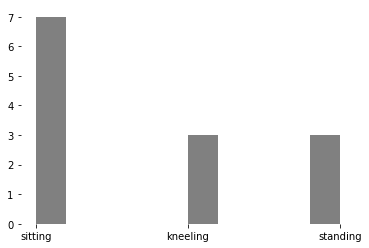

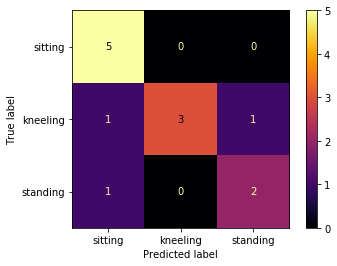

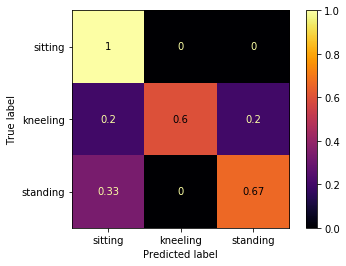

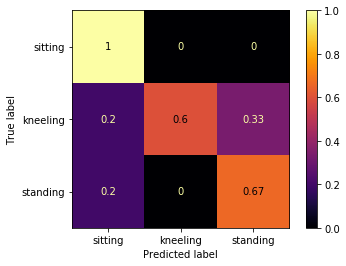

In [4]:
# prediction distribution
fig, ax = plt.subplots(1,1)
ax.hist(y_pred, color='grey')
ax.patch.set_alpha(0)
ax.set_frame_on(False)

# joint distribution
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot(cmap='inferno')

# conditional on y
row_sums = cm.sum(axis=1)
new_matrix = cm / row_sums[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=new_matrix,
                              display_labels=labels)
disp.plot(cmap='inferno')

# conditional on yhat
col_sums = cm.sum(axis=1)
new_matrix = cm / col_sums[np.newaxis, :]
disp = ConfusionMatrixDisplay(confusion_matrix=new_matrix,
                              display_labels=labels)
disp.plot(cmap='inferno')

# Continuous non-discrimination critera

To generate the distributions for this example, we will model the true data distribution as $$x \sim \mathcal N\left(0, \Sigma\right),\quad w \sim \mathcal N(0, \sigma^2),\quad y = \theta^\top x + w$$

Suppose that some $\hat\theta$ is used for predictions so $ \hat y = \hat \theta^\top x + w$.

Then the [joint distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Affine_transformation) is given by $$\begin{bmatrix} y \\ \hat y\end{bmatrix} = \mathcal N\left(0,\begin{bmatrix} \theta^\top \Sigma\theta + \sigma^2 & \theta^\top\Sigma \hat\theta\\ \theta^\top\Sigma \hat\theta & \hat\theta^\top\Sigma\hat\theta\end{bmatrix}\right) $$

The [conditional distributions](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) are given by
$$y\mid \hat y \sim \mathcal N\left(\frac{\theta^\top\Sigma\hat\theta}{\hat\theta^\top\Sigma\hat\theta}\hat y, \theta^\top\Sigma \theta + \sigma^2 - \frac{(\theta^\top\Sigma\hat\theta)^2}{\hat\theta^\top\Sigma\hat\theta} \right) \quad 
\hat y\mid  y \sim \mathcal N\left(\frac{ \theta^\top\Sigma\hat \theta}{\theta^\top\Sigma\theta+\sigma^2}y,\hat \theta^\top \Sigma\hat\theta  - \frac{(\theta^\top\Sigma\hat\theta)^2}{\theta^\top\Sigma\theta+\sigma^2} \right) $$

In [5]:
theta = np.array([1.1,2])
theta_hat = theta # np.array([2,1.9])
sigmasq = 0.5
a = 0.5
sigma_matrix = np.diag([a, 1-a])

tt = np.dot(theta, sigma_matrix @ theta)
th = np.dot(theta, sigma_matrix @ theta_hat)
hh = np.dot(theta_hat, sigma_matrix @ theta_hat)

pdf_joint = lambda y_vec: multivariate_normal.pdf(y_vec, 
                                              cov=np.array([[tt+sigmasq, th],[th, hh]]))

pdf_cond_hat = lambda y, yhat: multivariate_normal.pdf(y, mean=(th)/(hh)*yhat, 
                                              cov=tt+sigmasq-(th)**2/(hh))

pdf_cond_y = lambda y, yhat: multivariate_normal.pdf(yhat, mean=(th)/(tt+sigmasq)*y, 
                                              cov=hh-(th)**2/(tt+sigmasq))

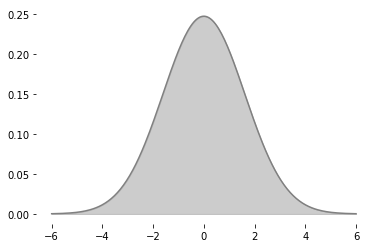

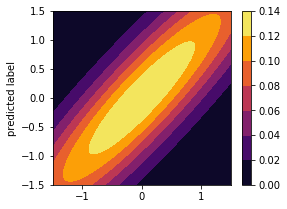

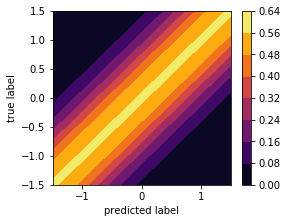

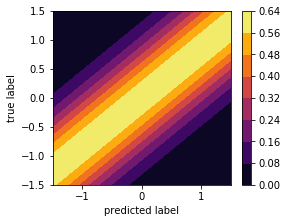

In [6]:
# very messy plotting code

ylin = np.linspace(-1.5, 1.5, 200)
yhatlin = np.linspace(-1.5, 1.5, 200)

y, yhat  = np.meshgrid(ylin, yhatlin)
pos = np.dstack((y, yhat))

fig, ax = plt.subplots(1, 1)
dist_hat = multivariate_normal.pdf(np.linspace(-6, 6, 200), cov=hh)
ax.plot(np.linspace(-6, 6, 200), dist_hat, color='grey')
ax.fill_between(np.linspace(-6, 6, 200), dist_hat, alpha=0.4, color='grey')
ax.patch.set_alpha(0)
ax.set_frame_on(False)
axs = []
figs = []
fig, ax = plt.subplots(1, 1, figsize=(4, 3.2))
axs += [ax]
figs += [fig]
fig, ax = plt.subplots(1, 1, figsize=(4, 3.2))
axs += [ax]
figs += [fig]
fig, ax = plt.subplots(1, 1, figsize=(4, 3.2))
axs += [ax]
figs += [fig]

ret = axs[0].contourf(yhat,y, pdf_joint(pos), cmap='inferno')
# axs[0].set_title('Joint distribution')
axs[0].set_ylabel('true label')
axs[0].set_ylabel('predicted label')
figs[0].colorbar(ret)

ret = axs[1].contourf(yhat, y,
               np.vstack([pdf_cond_hat(ylin[:,np.newaxis], yhati) for yhati in yhatlin]), cmap='inferno')
# axs[1].set_title('Distribution of y conditioned on y_hat')
axs[1].set_ylabel('true label')
axs[1].set_xlabel('predicted label')
figs[1].colorbar(ret)
ret = axs[2].contourf(yhat, y,
               np.vstack([pdf_cond_y(yi, yhatlin[:,np.newaxis]) for yi in ylin]), cmap='inferno')
# axs[2].set_title('Distribution of y_hat conditioned on y')
axs[2].set_ylabel('true label')
axs[2].set_xlabel('predicted label')
figs[2].colorbar(ret)



In [7]:
# # previous plotting attempt
# fig = plt.figure(figsize=(15, 5))
# axs = []
# axs += [fig.add_subplot(131, projection='3d')]
# axs += [fig.add_subplot(132, projection='3d')]
# axs += [fig.add_subplot(133, projection='3d')]

# def cool_3d_plot(X,Y,Z,ax):
#     ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
#                 alpha=0.3)
#     ax.contour(X, Y, Z, zdir='z', offset=-0.01, cmap='coolwarm')
#     ax.contour(X, Y, Z, zdir='x', offset=-1.5, cmap='coolwarm')
#     ax.contour(X, Y, Z, zdir='y', offset=1.5, cmap='coolwarm')
#     ax.set(xlim=(-1.5,1.5), ylim=(-1.5,1.5), zlim=(-.01,np.amax(Z)),
#        xlabel='y', ylabel='yhat')


# Z = pdf_joint(pos)
# cool_3d_plot(y,yhat,Z,axs[0])
# axs[0].set_title('Joint distribution')


# cool_3d_plot(y, yhat, 
#                np.vstack([pdf_cond_hat(ylin[:,np.newaxis], yhati) for yhati in yhatlin]), axs[1])
# axs[1].set_title('Distribution of y conditioned on y_hat')
# cool_3d_plot(y, yhat, 
#                np.vstack([pdf_cond_y(yi, yhatlin[:,np.newaxis]) for yi in ylin]), axs[2])
# axs[2].set_title('Distribution of y_hat conditioned on y')



# plt.tight_layout()